# MORDM optimization
## Imports


In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario, HypervolumeMetric
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Prepare model and settings

In [2]:
model, planning_steps = get_model_for_problem_formulation(2)

#The model requires a reference scenario to "kick-start"
reference_scenario = Scenario('reference', **{
    'discount rate-0': 1.5,
    'discount rate-1': 1.5,
    'discount rate-2': 1.5,
    'A.0_ID flood wave shape': 75,
    'A.1_Bmax': 240,
    'A.1_pfail': 0.25,
    'A.1_Brate': 10,
    'A.2_Bmax': 240,
    'A.2_pfail': 0.25,
    'A.2_Brate': 10,
    'A.3_Bmax': 240,
    'A.3_pfail': 0.25,
    'A.3_Brate': 10,
    'A.4_Bmax': 240,
    'A.4_pfail': 0.25,
    'A.4_Brate': 10,
    'A.5_Bmax': 240,
    'A.5_pfail': 0.25,
    'A.5_Brate': 10
})

nfe = 5000
epsilon = [0.5,0.5,0.5,0.01,0.01]

# Each epsilon value corresponds to a model outcome. The model outcomes are:
# expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
# We select higher epsilon values to damages and costs, while we choose lower values for evacuation costs and casualties.


## Optimize and study convergence

In [3]:
# Create the data folder if it doesn't exist, remove temp folder if it exists
Path("./MORDM_Data").mkdir(parents=True, exist_ok=True)
tmppath = Path('./MORDM_Data') / 'tmp'
if tmppath.exists() and tmppath.is_dir():
    shutil.rmtree(tmppath)

# Define the convergence metrics
convergence_metrics = [
    # Save data as archive
    ArchiveLogger(
        "./MORDM_Data",
        [l.name for l in model.levers],
        [o.name for o in model.outcomes],
        base_filename="MORDM_HV_1.tar.gz",
    ),
    # Track epsilon progress
    EpsilonProgress(),
]

# Optimize and study convergence
with MultiprocessingEvaluator(model) as evaluator:
    optimization_result, optimization_convergence = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon,  convergence=convergence_metrics,reference=reference_scenario)

[MainProcess/INFO] pool started with 10 workers
50205it [17:42, 47.26it/s]                                                     
[MainProcess/INFO] optimization completed, found 1282 solutions
[MainProcess/INFO] terminating pool


In [4]:
### Convergence epsilon plot

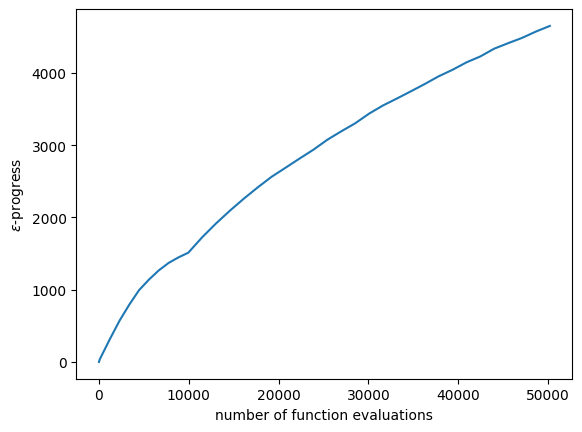

In [5]:
fig, ax = plt.subplots()
ax.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [6]:
print("Amount of results: " + str(len(optimization_result.index)))

from ema_workbench import save_results
#save_results(total, 'MORDM_100k_ep0.25.tar.gz'.format(nfe))

Amount of results: 1282


In [7]:
# Select only those policies that result in an tolerable # of deaths
result_constrained = optimization_result[optimization_result['Expected Number of Deaths'] < 0.001]
print("Amount of results with tolerable deaths: " + str(len(result_constrained.index)))
result_constrained


Amount of results with tolerable deaths: 29


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,0,0,0,0,0,0,0,0,0,0,...,5,0,6,0,0,0.000000e+00,2.023244e+08,0.000000e+00,0.000000,0.000000
32,0,1,1,0,0,0,0,0,0,0,...,1,0,7,0,0,0.000000e+00,1.739890e+08,1.692000e+08,0.000000,0.000000
59,1,1,0,0,0,0,0,0,0,0,...,5,0,5,0,0,6.726644e+06,1.544708e+08,1.692000e+08,197.675575,0.000357
109,1,0,1,0,0,0,1,1,1,0,...,2,0,7,0,0,0.000000e+00,1.433063e+08,2.613000e+08,0.000000,0.000000
153,1,0,0,1,1,1,0,1,1,1,...,0,0,1,0,0,1.298393e+07,1.096644e+08,1.419100e+09,283.183806,0.000863
179,1,0,0,0,1,0,1,1,1,1,...,1,0,3,0,0,0.000000e+00,1.178368e+08,1.014200e+09,0.000000,0.000000
201,1,0,1,0,0,0,1,0,1,1,...,2,0,1,0,0,2.080104e+07,1.044100e+08,5.942000e+08,629.803811,0.000872
261,1,0,1,0,0,0,1,0,1,0,...,2,0,2,0,0,2.019672e+07,1.135224e+08,4.730000e+08,595.718986,0.000886
268,1,0,0,0,0,0,1,1,1,0,...,0,0,7,0,0,9.369180e+06,1.717999e+08,1.767000e+08,193.835882,0.000636
393,0,1,1,0,0,0,0,1,0,0,...,0,0,6,0,0,9.612078e+06,1.421155e+08,1.999000e+08,245.228305,0.000535


In [8]:
def has_rfr_after_dh(series):
    for area in range(5):
        first_rfr_timestep = -1
        for timestep in range(3):
            if series[f"{area}_RfR {timestep}"] > 0:
                first_rfr_timestep = timestep
                break
        last_dike_timestep = 3
        for timestep in range(3):
            if series[f"A.{area + 1}_DikeIncrease {timestep}"] > 0:
                last_dike_timestep = timestep
        print(f"First RfR timestep: {first_rfr_timestep}; last DH timestep: {last_dike_timestep}")
        if first_rfr_timestep > last_dike_timestep:
            print("removing")
            return True

    print("keeping")
    return False

# Also remove policies that include RfR after dike heightening
result_constrained = result_constrained[result_constrained.apply(has_rfr_after_dh, axis="columns") == False]
print("Amount of results with tolerable deaths and no DH>RfR: " + str(len(result_constrained.index)))

First RfR timestep: -1; last DH timestep: 0
First RfR timestep: -1; last DH timestep: 0
First RfR timestep: -1; last DH timestep: 0
First RfR timestep: -1; last DH timestep: 1
First RfR timestep: -1; last DH timestep: 0
keeping
First RfR timestep: 1; last DH timestep: 3
First RfR timestep: -1; last DH timestep: 0
First RfR timestep: -1; last DH timestep: 0
First RfR timestep: -1; last DH timestep: 1
First RfR timestep: -1; last DH timestep: 0
keeping
First RfR timestep: 0; last DH timestep: 3
First RfR timestep: -1; last DH timestep: 0
First RfR timestep: -1; last DH timestep: 0
First RfR timestep: -1; last DH timestep: 1
First RfR timestep: -1; last DH timestep: 0
keeping
First RfR timestep: 0; last DH timestep: 3
First RfR timestep: -1; last DH timestep: 0
First RfR timestep: 0; last DH timestep: 0
First RfR timestep: -1; last DH timestep: 1
First RfR timestep: -1; last DH timestep: 0
keeping
First RfR timestep: 0; last DH timestep: 3
First RfR timestep: 0; last DH timestep: 0
First 

In [9]:
# Remove columns for outcomes from the dataframe, resulting in a df of polcies
policies = result_constrained.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,0,0,0,...,0,7,0,0,6,5,0,6,0,0
32,0,1,1,0,0,0,0,0,0,0,...,0,7,0,0,7,1,0,7,0,0
59,1,1,0,0,0,0,0,0,0,0,...,0,7,0,0,5,5,0,5,0,0
109,1,0,1,0,0,0,1,1,1,0,...,0,3,0,0,6,2,0,7,0,0
201,1,0,1,0,0,0,1,0,1,1,...,0,3,0,0,0,2,0,1,0,0
261,1,0,1,0,0,0,1,0,1,0,...,0,3,0,0,1,2,0,2,0,0
268,1,0,0,0,0,0,1,1,1,0,...,0,4,0,0,5,0,0,7,0,0
419,0,0,0,0,0,0,1,1,1,0,...,0,3,0,0,7,0,0,7,0,0
436,1,1,0,0,0,0,1,0,1,1,...,0,3,0,0,7,0,0,1,0,0
529,1,1,0,0,0,0,1,1,1,1,...,0,3,0,0,4,1,0,3,0,0


### Parcoords plots

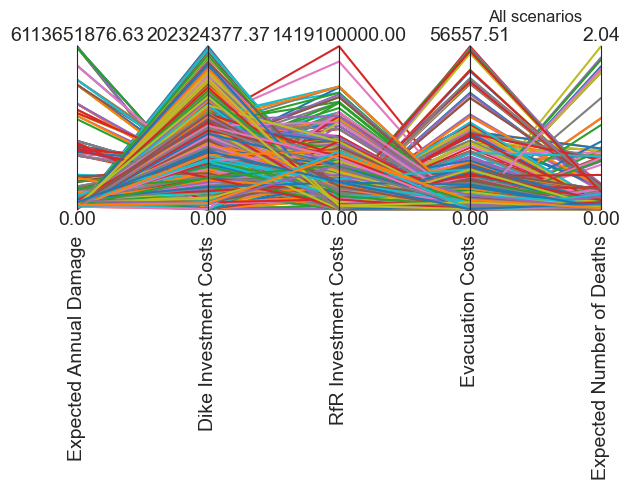

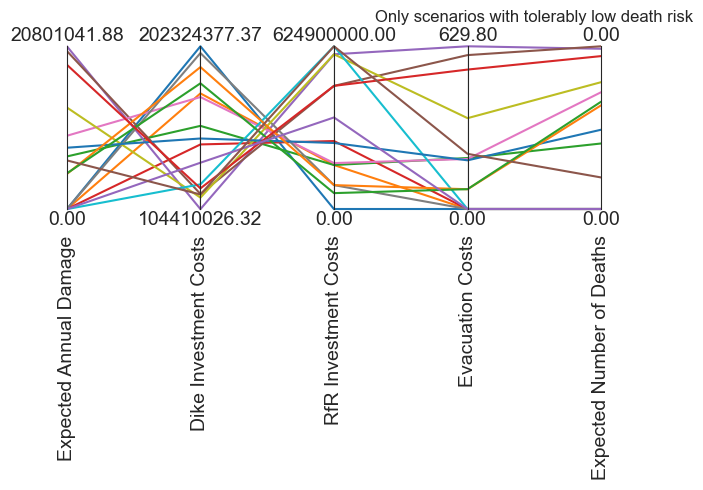

In [10]:
from ema_workbench.analysis import parcoords

data = optimization_result.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.title("All scenarios")
plt.show()


data = result_constrained.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.title("Only scenarios with tolerably low death risk")
plt.show()

In [11]:
# Load data from archive (necessary?)
archives = ArchiveLogger.load_archives("./MORDM_Data/MORDM_HV_1.tar.gz")

## Hypervolume

Here, there is an issue between the dike model and the EMA Workbench. The dike model defines value keys (levers, uncertainties, outcomes) that do not follow Python identifier standards, by including spaces or dots, or starting with digits.

We avoid this by replacing disallowed symbols with allowed (but otherwise unused) symbols, Ç and Ñ. We also add the letter "A" in front of keys starting with digits.

In [12]:
from copy import deepcopy

result_sanitized = optimization_result.copy()
model_sanitized = deepcopy(model)

# Here, we need to rename...
def sanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace(".","Ç")
    # Replace spaces
    x = x.replace(" ","Ñ")
    # Add letter if starts with digit
    if x.startswith(("0","1","2","3","4","5")):
        x = "A" + x
    return x

# Reverse functions for if we need to get the original labels...
def desanitize_as_python_identifier(x):
    # Replace dots
    x = x.replace("Ç",".")
    # Replace spaces
    x = x.replace("Ñ"," ")
    # Add letter if starts with digit
    if x.startswith(("A0","A1","A2","A3","A4","A5")):
        x = x[1:]
    return x

result_sanitized.columns = [sanitize_as_python_identifier(x) for x in result_sanitized.columns]

for lev in model_sanitized.levers:
    lev.name = sanitize_as_python_identifier(lev.name)

for unc in model_sanitized.uncertainties:
    unc.name = sanitize_as_python_identifier(unc.name)

for out in model_sanitized.outcomes:
    out.name = sanitize_as_python_identifier(out.name)

In [13]:
problem = to_problem(model_sanitized, searchover="levers")

hv = HypervolumeMetric(result_sanitized, problem)

print(f"Going over {len(archives.items())} archives...")
hypervolume = []
for i, (nfe, archive) in enumerate(archives.items()):
    print("Hypervolume calculate for archive #" + str(i))
    archive_sanitized = archive
    archive_sanitized.columns = [sanitize_as_python_identifier(x) for x in archive_sanitized.columns]
    the_result = (nfe, hv.calculate(archive))
    hypervolume.append(the_result)

hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)


Going over 37 archives...
Hypervolume calculate for archive #0
Hypervolume calculate for archive #1
Hypervolume calculate for archive #2
Hypervolume calculate for archive #3
Hypervolume calculate for archive #4
Hypervolume calculate for archive #5
Hypervolume calculate for archive #6
Hypervolume calculate for archive #7
Hypervolume calculate for archive #8
Hypervolume calculate for archive #9
Hypervolume calculate for archive #10


KeyboardInterrupt: 

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylim(ymin=0)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

Filtering the found solutions to those that are most important for the Delta Commission.